<a href="https://colab.research.google.com/github/sundarjhu/Astrostatistics2025/blob/main/Lesson10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# The Multivariate Gaussian & the Role of the Covariance Matrix
**Objectives:**
1. Geometric intuition for the covariance matrix via 2D Gaussians.
2. Connect covariance to principal axes (eigendecomposition).
3. Use covariance to define the Mahalanobis distance.
4. Generate correlated Gaussians via linear transformations (Cholesky).

> All plots use Matplotlib and avoid external styling for reproducibility.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

rng = np.random.default_rng(42)

def plot_gaussian_contours(mu, Sigma, ax=None, levels=(0.1, 0.3, 0.5, 0.7, 0.9)):
    if ax is None:
        ax = plt.gca()
    vals, _ = np.linalg.eigh(Sigma)
    span = 4.0 * np.sqrt(vals.max())
    x = np.linspace(mu[0]-span, mu[0]+span, 200)
    y = np.linspace(mu[1]-span, mu[1]+span, 200)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean=mu, cov=Sigma)
    Z = rv.pdf(pos)
    cs = ax.contour(X, Y, Z, levels=np.quantile(Z, levels))
    return cs

def joint_marginal_plot(x, y, bins=40, title=None):
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           wspace=0.05, hspace=0.05)
    ax_joint = fig.add_subplot(gs[1, 0])
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_joint)
    ax_right = fig.add_subplot(gs[1, 1], sharey=ax_joint)

    ax_joint.scatter(x, y, s=5, alpha=0.35)
    ax_top.hist(x, bins=bins)
    ax_right.hist(y, bins=bins, orientation="horizontal")

    plt.setp(ax_top.get_xticklabels(), visible=False)
    plt.setp(ax_right.get_yticklabels(), visible=False)
    ax_top.tick_params(axis='x', which='both', length=0)
    ax_right.tick_params(axis='y', which='both', length=0)

    ax_joint.set_xlabel("x1")
    ax_joint.set_ylabel("x2")
    if title:
        fig.suptitle(title, y=0.98)
    return fig, ax_joint, ax_top, ax_right


## 1. Correlated vs. Uncorrelated 2D Gaussians
**Concept:** The covariance matrix controls *shape* (eccentricity) and *orientation*.
$
\Sigma_0=\begin{pmatrix}1&0\\0&1\end{pmatrix},\quad
\Sigma_+ = \begin{pmatrix}1&0.8\\0.8&1\end{pmatrix},\quad
\Sigma_- = \begin{pmatrix}1&-0.8\\-0.8&1\end{pmatrix}.
$


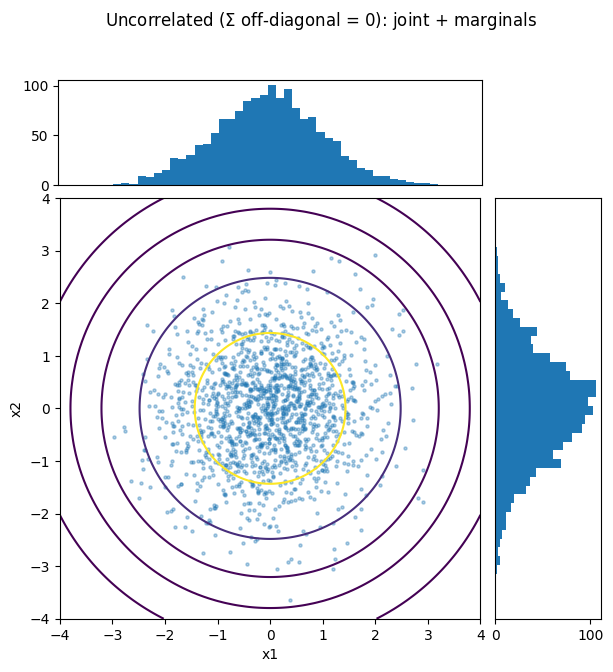

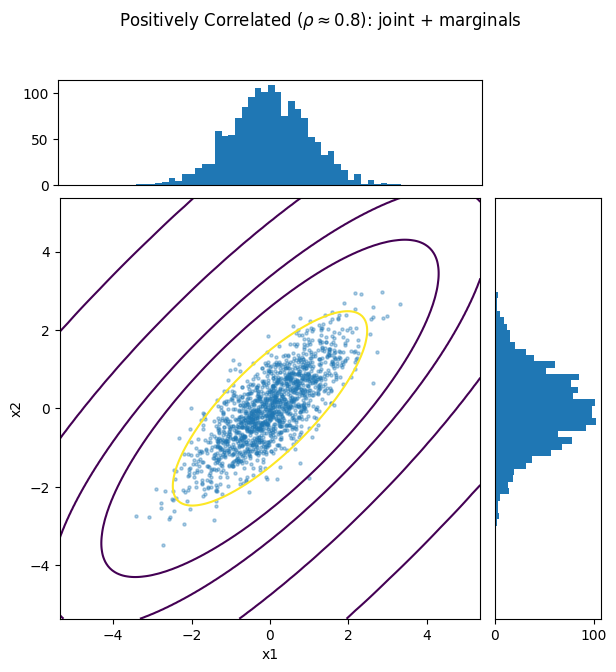

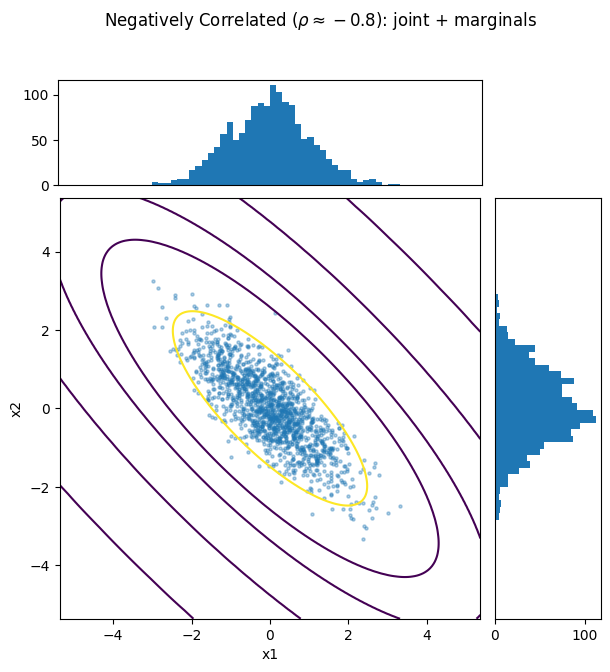

In [2]:

mu = np.array([0.0, 0.0])
Sigma0 = np.array([[1.0, 0.0],[0.0, 1.0]])
Sigmap = np.array([[1.0, 0.8],[0.8, 1.0]])
Sigman = np.array([[1.0, -0.8],[-0.8, 1.0]])
X0 = rng.multivariate_normal(mu, Sigma0, size=1500)
Xp = rng.multivariate_normal(mu, Sigmap, size=1500)
Xn = rng.multivariate_normal(mu, Sigman, size=1500)

# Uncorrelated
fig, ax_joint, ax_top, ax_right = joint_marginal_plot(X0[:,0], X0[:,1],
                                                      title=r"Uncorrelated ($\Sigma$ off-diagonal = 0): joint + marginals")
plot_gaussian_contours(mu, Sigma0, ax=ax_joint)
ax_joint.set_aspect("equal", adjustable="box")
plt.show()

# Positive corr
fig, ax_joint, ax_top, ax_right = joint_marginal_plot(Xp[:,0], Xp[:,1],
                                                      title=r"Positively Correlated ($\rho\approx 0.8$): joint + marginals")
plot_gaussian_contours(mu, Sigmap, ax=ax_joint)
ax_joint.set_aspect("equal", adjustable="box")
plt.show()

# Negative corr
fig, ax_joint, ax_top, ax_right = joint_marginal_plot(Xn[:,0], Xn[:,1],
                                                      title=r"Negatively Correlated ($\rho\approx -0.8$): joint + marginals")
plot_gaussian_contours(mu, Sigman, ax=ax_joint)
ax_joint.set_aspect("equal", adjustable="box")
plt.show()



## 5. Multivariate Gaussian Log-Likelihood
$
\log p(x \mid \mu, \Sigma) = -\frac{1}{2}\Big(d \log 2\pi + \log|\Sigma| + (x-\mu)^\top \Sigma^{-1} (x-\mu)\Big).
$
Determinant $|\Sigma|$ controls volume; precision $\Sigma^{-1}$ controls the quadratic penalty.


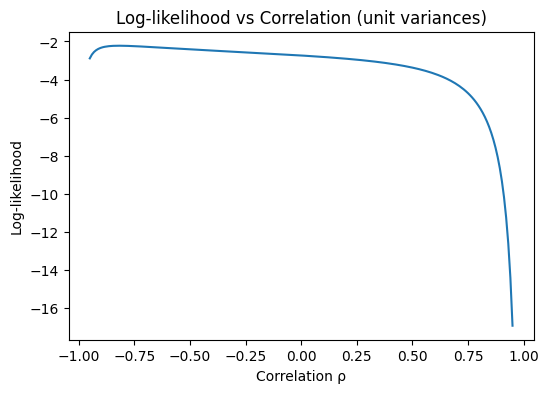

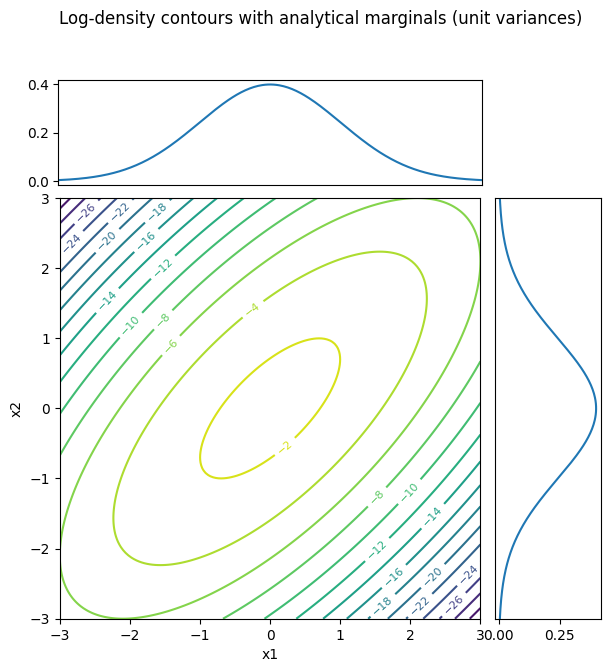

In [6]:

import numpy as np
import matplotlib.pyplot as plt

x_obs = np.array([1.2, -0.6])
mu0 = np.zeros(2)
rhos = np.linspace(-0.95, 0.95, 200)

def loglike_bivar(x, mu, rho):
    det = 1 - rho**2
    inv = (1.0/det) * np.array([[1, -rho],[-rho, 1]])
    diff = x - mu
    mahal = diff @ inv @ diff
    ll = -0.5*(2*np.log(2*np.pi) + np.log(det) + mahal)
    return ll

ll_vals = np.array([loglike_bivar(x_obs, mu0, r) for r in rhos])

plt.figure(figsize=(6,4))
plt.plot(rhos, ll_vals)
plt.xlabel("Correlation ρ")
plt.ylabel("Log-likelihood")
plt.title("Log-likelihood vs Correlation (unit variances)")
plt.show()

# rho_fix = 0.7
# det = 1 - rho_fix**2
# inv = (1.0/det) * np.array([[1, -rho_fix],[-rho_fix, 1]])

# x1 = np.linspace(-3, 3, 120)
# x2 = np.linspace(-3, 3, 120)
# X1, X2 = np.meshgrid(x1, x2)
# D = np.stack([X1, X2], axis=-1)
# diff = D - mu0
# mahal = diff[...,0]*(inv[0,0]*diff[...,0] + inv[0,1]*diff[...,1]) + \
#         diff[...,1]*(inv[1,0]*diff[...,0] + inv[1,1]*diff[...,1])
# logpdf = -0.5*(2*np.log(2*np.pi) + np.log(det) + mahal)

# plt.figure(figsize=(6,5))
# cs = plt.contour(X1, X2, logpdf, levels=15)
# plt.clabel(cs, inline=True, fontsize=8)
# plt.scatter([x_obs[0]], [x_obs[1]])
# plt.title("Log-density contours for ρ = {:.2f}".format(rho_fix))
# plt.xlabel("x1"); plt.ylabel("x2")
# plt.axis("equal")
# plt.show()


# 2D log-density with unit variances and rho=0.7; show analytical 1D marginals
rho_fix = 0.7
mu0 = np.zeros(2)
x1 = np.linspace(-3, 3, 160)
x2 = np.linspace(-3, 3, 160)
X1, X2 = np.meshgrid(x1, x2)
det = 1 - rho_fix**2
inv = (1.0/det) * np.array([[1, -rho_fix],[-rho_fix, 1]])
D = np.stack([X1, X2], axis=-1)
diff = D - mu0
mahal = diff[...,0]*(inv[0,0]*diff[...,0] + inv[0,1]*diff[...,1]) + \
        diff[...,1]*(inv[1,0]*diff[...,0] + inv[1,1]*diff[...,1])
logpdf = -0.5*(2*np.log(2*np.pi) + np.log(det) + mahal)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)
ax_joint = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_joint)

cs = ax_joint.contour(X1, X2, logpdf, levels=15)
ax_joint.clabel(cs, inline=True, fontsize=8)
ax_joint.set_xlabel("x1"); ax_joint.set_ylabel("x2")
ax_joint.set_aspect("equal", adjustable="box")
fig.suptitle("Log-density contours with analytical marginals (unit variances)", y=0.98)

xgrid = np.linspace(-3, 3, 300)
phi = (1/np.sqrt(2*np.pi))*np.exp(-0.5*xgrid**2)
ax_top.plot(xgrid, phi)
ygrid = np.linspace(-3, 3, 300)
phi_y = (1/np.sqrt(2*np.pi))*np.exp(-0.5*ygrid**2)
ax_right.plot(phi_y, ygrid)

plt.setp(ax_top.get_xticklabels(), visible=False)
plt.setp(ax_right.get_yticklabels(), visible=False)
ax_top.tick_params(axis='x', which='both', length=0)
ax_right.tick_params(axis='y', which='both', length=0)

plt.show()




## 6. Minimal Gaussian Process Demo
Prior and posterior with an RBF kernel $k(x,x')=\sigma_f^2\exp\Big[-\tfrac{(x-x')^2}{2\ell^2}\Big]$.


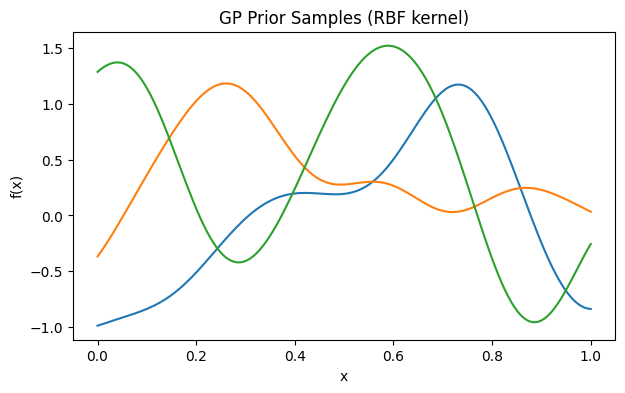

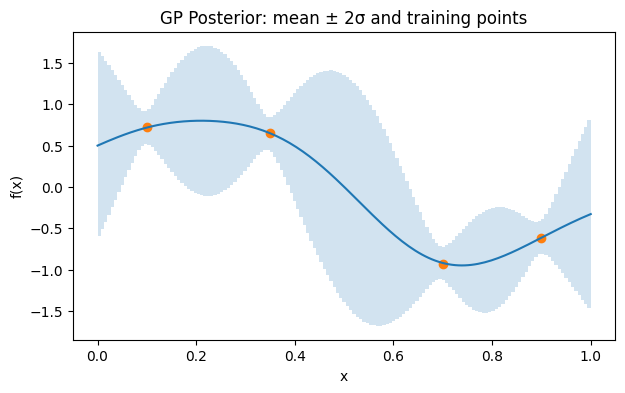

In [7]:

import numpy as np
import matplotlib.pyplot as plt

def rbf_kernel(xa, xb, sigma_f=1.0, ell=0.25):
    xa = np.atleast_2d(xa).reshape(-1,1)
    xb = np.atleast_2d(xb).reshape(-1,1)
    sqdist = (xa - xb.T)**2
    return sigma_f**2 * np.exp(-0.5 * sqdist / (ell**2))

X = np.linspace(0, 1, 150)
K = rbf_kernel(X, X, sigma_f=1.0, ell=0.15)

rng = np.random.default_rng(123)
L = np.linalg.cholesky(K + 1e-10*np.eye(len(X)))
fs = (L @ rng.standard_normal((len(X), 3))).T

plt.figure(figsize=(7,4))
for f in fs:
    plt.plot(X, f)
plt.title("GP Prior Samples (RBF kernel)")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.show()

X_train = np.array([0.1, 0.35, 0.7, 0.9])
f_true = np.sin(2*np.pi*X_train)
sigma_n = 0.1
y_train = f_true + sigma_n*rng.standard_normal(len(X_train))

K_xx = rbf_kernel(X_train, X_train, ell=0.15)
K_xX = rbf_kernel(X, X_train, ell=0.15)
K_xx_noise = K_xx + (sigma_n**2)*np.eye(len(X_train))

alpha = np.linalg.solve(K_xx_noise, y_train)
mu_post = K_xX @ alpha
v = np.linalg.solve(K_xx_noise, K_xX.T)
K_xx_post = rbf_kernel(X, X, ell=0.15) - K_xX @ v

std_post = np.sqrt(np.clip(np.diag(K_xx_post), 0, None))

plt.figure(figsize=(7,4))
plt.fill_between(X, mu_post-2*std_post, mu_post+2*std_post, alpha=0.2, step='pre')
plt.plot(X, mu_post)
plt.scatter(X_train, y_train)
plt.title("GP Posterior: mean ± 2σ and training points")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.show()
